<a href="https://colab.research.google.com/github/AyyappaSwamyPanthadi/TimeSeriesPrediction/blob/master/TimeSeriesPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/GoogleCloudPlatform/training-data-analyst 

fatal: destination path 'training-data-analyst' already exists and is not an empty directory.


In [ ]:
%pip install -U statsmodels --user

Requirement already up-to-date: statsmodels in /root/.local/lib/python3.6/site-packages (0.11.1)


In [ ]:
from google.cloud import bigquery as bq
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
target_col = 'y'  # What we are predicting
ts_col = 'ds'     # Time series column
holiday_col = 'holiday'

daily_file = 'iowa_daily.csv'
monthly_file = 'iowa_monthly.csv'

### Dataset

The [Iowa Liquor Sales](https://console.cloud.google.com/marketplace/details/iowa-department-of-commerce/iowa-liquor-sales) dataset from BigQuery Public Datasets is used in this example. The dataset contains wholesale liquor purchases in the state of Iowa from 2012 to the present.

In [ ]:
directory_path = "./training-data-analyst/courses/ai-for-time-series/notebooks/data/"

df_daily = pd.read_csv(directory_path + daily_file, index_col="ds", parse_dates=True)
df_monthly = pd.read_csv(directory_path + monthly_file, index_col="ds", parse_dates=True)

## Explore monthly data

In [ ]:
df_monthly.head()

y
ds                     
2012-01-01  15916194.22
2012-02-01  18116104.07
2012-03-01  18139545.75
2012-04-01  20004896.97
2012-05-01  22193521.24

In [ ]:
# Summery statistics
df_monthly[target_col].describe()

count    1.010000e+02
mean     2.486566e+07
std      4.574761e+06
min      1.591619e+07
25%      2.185890e+07
50%      2.442968e+07
75%      2.807811e+07
max      3.502633e+07
Name: y, dtype: float64

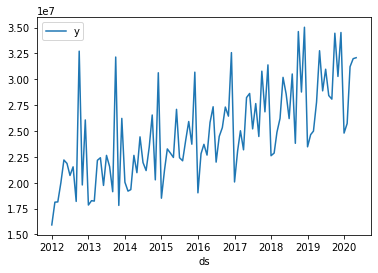

In [ ]:
# Plot the time-series data

_ = sns.lineplot(data=df_monthly)

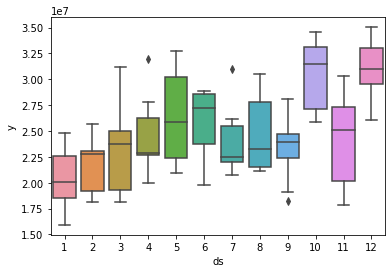

In [ ]:
# Show the distribution of values for each month in a boxplot:
# Min, 25th percentile, median, 75th percentile, max 

months = df_monthly.index.to_series().dt.month

_ = sns.boxplot(x=months, y=df_monthly[target_col])

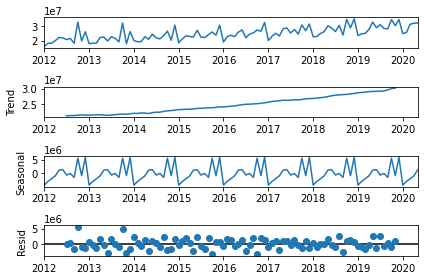

In [ ]:
# Decompose the data into trend and seasonal components

result = seasonal_decompose(df_monthly, period=12)
fig = result.plot()

## Explore daily data

In [ ]:
df_daily.head()

y  holiday
ds                             
2012-01-03  1012493.81      0.0
2012-01-04   860053.73      0.0
2012-01-05   940194.93      0.0
2012-01-06        0.00      0.0
2012-01-07        0.00      0.0

In [ ]:
df_daily[target_col].describe()

count    3.070000e+03
mean     8.180561e+05
std      6.740808e+05
min      0.000000e+00
25%      0.000000e+00
50%      1.061111e+06
75%      1.374018e+06
max      3.516318e+06
Name: y, dtype: float64

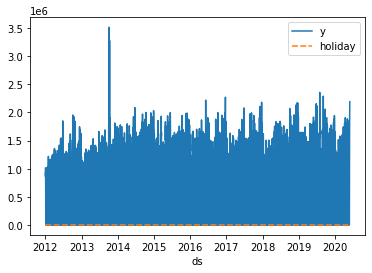

In [ ]:
# Let's plot the data. Note the outlier in 2013.

result = sns.lineplot(data=df_daily)
fig = result.plot()

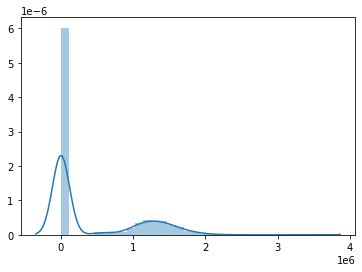

In [ ]:
# Plot the overall data distribution

result = sns.distplot(df_daily)
fig = result.plot()

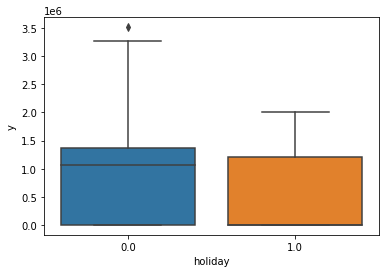

In [ ]:
# See any meaningful difference on holidays?
result = sns.boxplot(x=holiday_col, y=target_col, data=df_daily)
fig = result.plot()

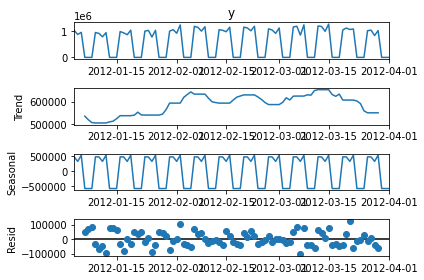

In [ ]:
# Look for weekly seasonality (just showing 90 days so pattern is clearer)

result = seasonal_decompose(df_daily[target_col][0:90], period=7)
fig = result.plot()

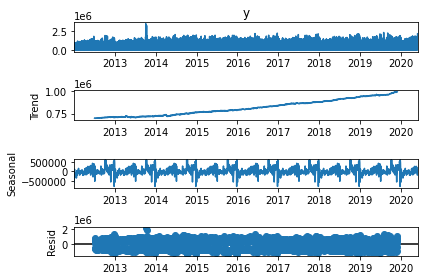

In [ ]:
# now decomposing by year
result = seasonal_decompose(df_daily[target_col], period=365)
fig = result.plot()



---




## **Model Building**


In [ ]:
import numpy as np

from google.cloud import storage
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, LSTM, MaxPooling1D

register_matplotlib_converters() # Address warning

In [ ]:
n_features = 2 # Two features: y (previous values) and whether the date is a holiday
n_input_steps = 30 # Lookback window
n_output_steps = 7 # How many steps to predict forward
n_seasons = 7 # Weekly periodicity

In [ ]:
train_split = 0.75 # % Split between train/test data
epochs = 1000 # How many passes through the data (early-stopping will cause training to stop before this)
patience = 5 # Terminate training after the validation loss does not decrease after this many epochs

In [ ]:
# Split data
size = int(len(df_daily) * train_split)
df_train, df_test = df_daily[0:size].copy(deep=True), df_daily[size:len(df_daily)].copy(deep=True)

df_train.head()

y  holiday
ds                             
2012-01-03  1012493.81      0.0
2012-01-04   860053.73      0.0
2012-01-05   940194.93      0.0
2012-01-06        0.00      0.0
2012-01-07        0.00      0.0

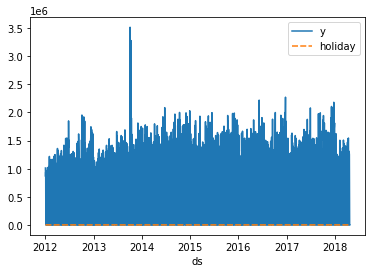

In [ ]:
# Notice any outliers in the data? Make note of the value.

# The _= syntax avoids printing out the type of the plot. _ is a Python convention for "I don't care about this variable"
_=sns.lineplot(data=df_train)

In [ ]:
threshold = 2e6 # Set this to a level which will flag outliers (any values above it)
assert threshold != -1, 'Set the threshold to the minimum that will eliminate outlier(s)'
# Set any values above the threshold to NaN (not a number)
df_train.loc[df_train[target_col] > threshold, target_col] = np.nan

# Interpolate the missing values (e.g. [3, NaN, 5] becomes [3, 4, 5])
df_train = df_train.interpolate()

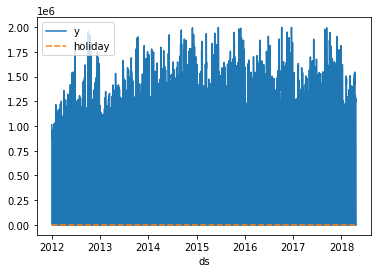

In [ ]:
_=sns.lineplot(data=df_train)

## Feature Scaling

In [ ]:
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

def scale(df, 
          fit=True, 
          target_col=target_col,
          feature_scaler=feature_scaler,
          target_scaler=target_scaler):
    target = df[target_col].values.reshape(-1, 1)
    if fit:
        target_scaler.fit(target)
    data_scaled = target_scaler.transform(target)
    
    features = df.loc[:, df.columns != target_col].values
    if features.shape[1]:
        if fit:
            feature_scaler.fit(features)
        features_scaled = feature_scaler.transform(features)
        data_scaled = np.concatenate([data_scaled, features_scaled], axis=1)

    df_scaled = pd.DataFrame(data_scaled, columns=df.columns)
    
    return df_scaled

def inverse_scale(data, target_scaler=target_scaler):
    df = pd.DataFrame()
    data_scaled = np.empty([data.shape[1], data.shape[0]])
    for i in range(data.shape[1]):
        data_scaled[i] = target_scaler.inverse_transform(data[:,i])
    return data_scaled.transpose()

df_train_scaled=scale(df_train)
df_test_scaled=scale(df_test, False)

## Creating sequences of time-series data

In [ ]:
def reframe(data, n_input_steps = n_input_steps, n_output_steps = n_output_steps):

    # Iterate through data and create sequences of features and outputs
    df = pd.DataFrame(data)
    cols=list()
    for i in range(n_input_steps, 0, -1):
        cols.append(df.shift(i))
    for i in range(0, n_output_steps):
        cols.append(df.shift(-i))
        
    # Concatenate values and remove any missing values
    df = pd.concat(cols, axis=1)
    df.dropna(inplace=True)
    
    # Split the data into feature and target variables
    n_feature_cols = n_input_steps * n_features
    features = df.iloc[:,0:n_feature_cols]
    target_cols = [i for i in range(n_feature_cols, n_feature_cols + n_output_steps * n_features, n_features)]
    targets = df.iloc[:,target_cols]

    return (features, targets)

X_train_reframed, y_train_reframed = reframe(df_train_scaled)
X_test_reframed, y_test_reframed = reframe(df_test_scaled)

## Evaluate results

In [ ]:
def print_stats(timestamp, y_true, y_pred, chart=True, table=False, dec=3):
  """summary statistics and stats for each time step"""

  print('=== t+' + str(timestamp) + ' ===')
  print('R^2: ' + str(np.round(r2_score(y_true, y_pred), dec)))
  print('MAE: ' + str(np.round(mean_absolute_error(y_true, y_pred), dec)))
  print('')

  df_y_true = pd.DataFrame(y_true)
  df_y_true[target_col + '_pred'] = np.round(y_pred, dec)

  if table:
    print(str(df_y_true.head(5)) + '\n')
    print(str(df_y_true.tail(5)) + '\n')

  if chart:
    sns.lineplot(data=df_y_true[[target_col, target_col+'_pred']])
    plt.show()


def evaluate(y_pred,
             exclude_timesteps = n_input_steps,
             y_true=df_test):
  # Number of outputs (future timesteps)
  outputs = y_pred.shape[1]

  # Lists of actual and predicted values for each time step
  # For example, y_true_eval[2] will contain actual values 3 time steps out
  # These specific lists enable computing the accuracy for specific time steps
  y_true_eval, y_pred_eval = list(), list()

  # Actual and predicted values combined across all time steps (to compute overall accuracy metrics)
  y_true_all, y_pred_all = np.array([]), np.array([])
  
  # Append entries to lists for each output timestep
  for t in range(outputs):
    if exclude_timesteps:
      y_true_eval.append(y_true[exclude_timesteps+t : outputs*-2 + t].copy())
      y_pred_eval.append(y_pred[:outputs*-1 - 1,t])          
    else:
      y_true_eval.append(y_true[t:].copy())
      y_pred_eval.append(y_pred[:-1,t] if t == 0 else y_pred[:-1*t-1,t])
    
    # Append the output values to the combined lists
    y_true_all = np.concatenate([y_true_all, y_true_eval[t].values[:,0]], axis=0)
    y_pred_all = np.concatenate([y_pred_all, y_pred_eval[t]], axis=0)

  # Print aggregate statistics across all time steps (only if predicting multiple time steps)
  if outputs > 1:
    print_stats('(1-' + str(outputs) + ')', y_true_all, y_pred_all, False)

  # Print stats for each future time step
  for t in range(outputs):    
    print_stats(t+1, y_true_eval[t][target_col], y_pred_eval[t], True)

## ML Models

### Long Short Term Memory (LSTM)

In [ ]:
# Reshape test data to match model inputs and outputs

X_train = X_train_reframed.values.reshape(X_train_reframed.shape[0], n_input_steps, n_features)
X_test = X_test_reframed.values.reshape(X_test_reframed.shape[0], n_input_steps, n_features)
y_train = y_train_reframed.values.reshape(y_train_reframed.shape[0], n_output_steps, 1)
y_test = y_test_reframed.values.reshape(y_test_reframed.shape[0], n_output_steps, 1)

In [ ]:
model = Sequential([
    LSTM(64, input_shape=[n_input_steps, n_features], recurrent_activation=None),
    Dense(n_output_steps)])

model.compile(optimizer='adam', loss='mae')

early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
_ = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[early_stopping])

Epoch 1/1000
71/71 [==============================] - 1s 20ms/step - loss: 0.7250 - val_loss: 0.5619
Epoch 2/1000
71/71 [==============================] - 1s 15ms/step - loss: 0.3857 - val_loss: 0.4547
Epoch 3/1000
71/71 [==============================] - 1s 15ms/step - loss: 0.2946 - val_loss: 0.3836
Epoch 4/1000
71/71 [==============================] - 1s 16ms/step - loss: 0.2631 - val_loss: 0.3603
Epoch 5/1000
71/71 [==============================] - 1s 15ms/step - loss: 0.2517 - val_loss: 0.3470
Epoch 6/1000
71/71 [==============================] - 1s 15ms/step - loss: 0.2456 - val_loss: 0.3396
Epoch 7/1000
71/71 [==============================] - 1s 15ms/step - loss: 0.2396 - val_loss: 0.3360
Epoch 8/1000
71/71 [==============================] - 1s 16ms/step - loss: 0.2364 - val_loss: 0.3470
Epoch 9/1000
71/71 [==============================] - 1s 15ms/step - loss: 0.2327 - val_loss: 0.3497
Epoch 10/1000
71/71 [==============================] - 1s 15ms/step - loss: 0.2263 - val_lo

In [ ]:
model.save('./lstm_export/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./lstm_export/assets


=== t+(1-7) ===
R^2: 0.739
MAE: 226943.877

=== t+1 ===
R^2: 0.726
MAE: 235812.268



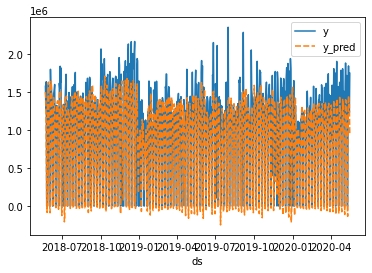

=== t+2 ===
R^2: 0.725
MAE: 236962.334



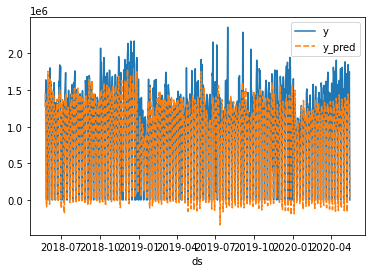

=== t+3 ===
R^2: 0.727
MAE: 228090.178



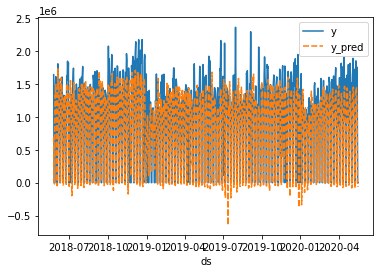

=== t+4 ===
R^2: 0.741
MAE: 224847.2



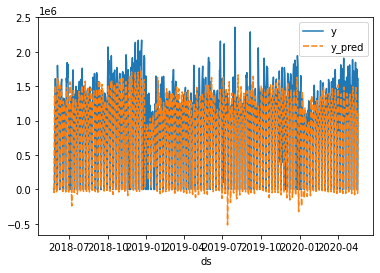

=== t+5 ===
R^2: 0.756
MAE: 219140.272



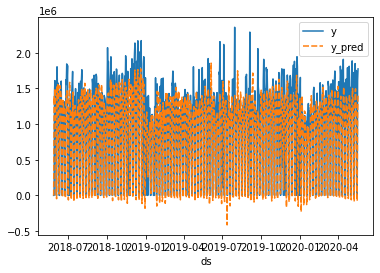

=== t+6 ===
R^2: 0.746
MAE: 225563.352



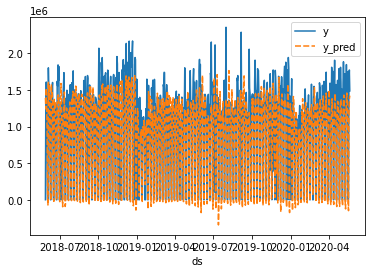

=== t+7 ===
R^2: 0.752
MAE: 218191.537



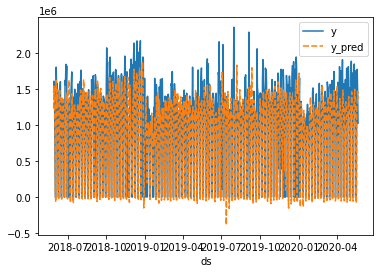

In [ ]:

# Predict the results, and then reverse the transformation that scaled all values to a mean of 0 and std. dev. of 1
preds = model.predict(X_test)
y_pred_lstm = inverse_scale(preds)

# Evaluate the overall results and for each time step
evaluate(y_pred_lstm)

### Convolutional Neural Network (CNN)

In [ ]:
  # Try adjusting the # of filters (pattern types) and kernel size (size of the sliding window)
  model = Sequential([
                      Conv1D(filters=32, kernel_size=4, activation="tanh", padding="causal", input_shape=[n_input_steps, n_features]),
                      Flatten(),
                      Dense(n_output_steps)
  ])

  model.compile(optimizer="adam", loss="mae")

  early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
  _ = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[early_stopping])

Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.4091 - val_loss: 0.3221
Epoch 2/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.2714 - val_loss: 0.3072
Epoch 3/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.2642 - val_loss: 0.3025
Epoch 4/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.2625 - val_loss: 0.3011
Epoch 5/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.2609 - val_loss: 0.3003
Epoch 6/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.2595 - val_loss: 0.2974
Epoch 7/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.2593 - val_loss: 0.2991
Epoch 8/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.2598 - val_loss: 0.2948
Epoch 9/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.2587 - val_loss: 0.2935
Epoch 10/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.2582 - val_loss: 0.2924

In [ ]:
model.save('./cnn_export/')

INFO:tensorflow:Assets written to: ./cnn_export/assets


=== t+(1-7) ===
R^2: 0.786
MAE: 188071.592

=== t+1 ===
R^2: 0.778
MAE: 195556.563



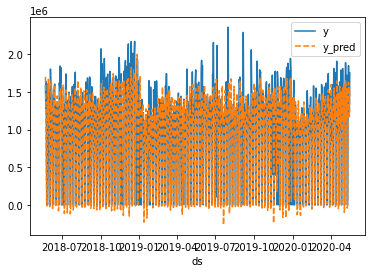

=== t+2 ===
R^2: 0.782
MAE: 190624.322



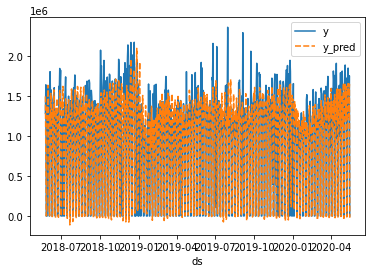

=== t+3 ===
R^2: 0.785
MAE: 189500.055



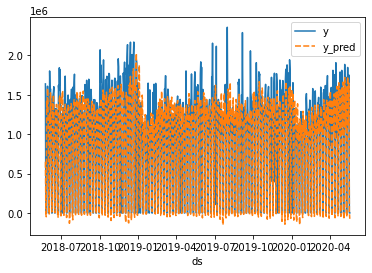

=== t+4 ===
R^2: 0.789
MAE: 188425.891



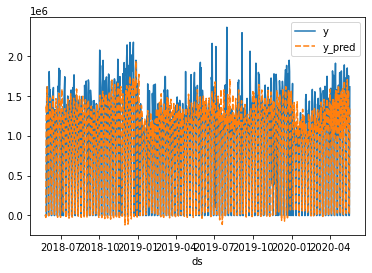

=== t+5 ===
R^2: 0.785
MAE: 187838.298



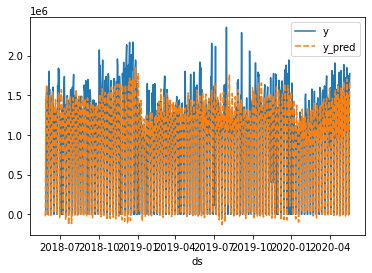

=== t+6 ===
R^2: 0.788
MAE: 182256.897



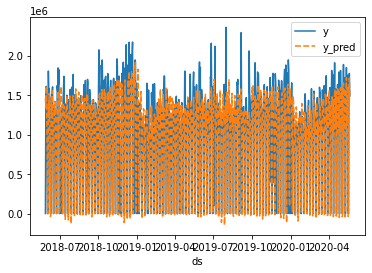

=== t+7 ===
R^2: 0.794
MAE: 182299.122



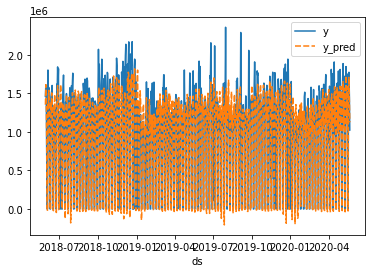

In [ ]:
preds = model.predict(X_test)
y_pred_cnn = inverse_scale(preds)

evaluate(y_pred_cnn)

### Ensembled Model

Often, combining multiple models that use diverse approaches can lead to better results than any individual model.

=== t+(1-7) ===
R^2: 0.767
MAE: 207963.015

=== t+1 ===
R^2: 0.758
MAE: 215875.317



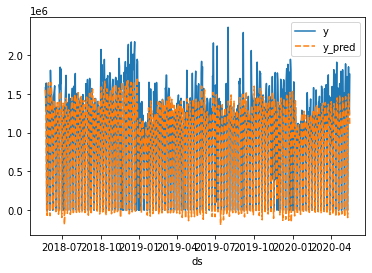

=== t+2 ===
R^2: 0.761
MAE: 214548.043



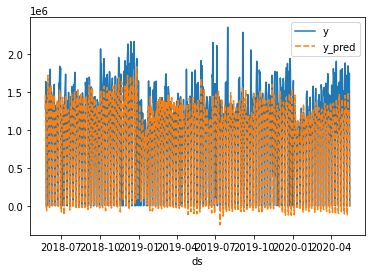

=== t+3 ===
R^2: 0.76
MAE: 209198.02



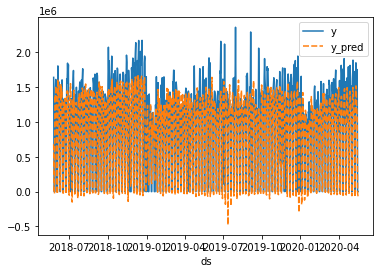

=== t+4 ===
R^2: 0.768
MAE: 206400.918



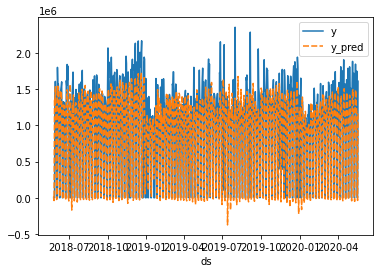

=== t+5 ===
R^2: 0.774
MAE: 203529.145



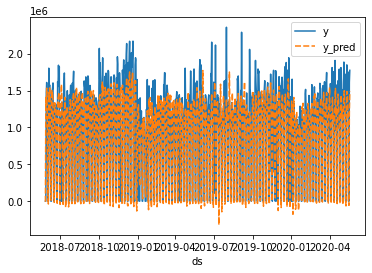

=== t+6 ===
R^2: 0.77
MAE: 205508.774



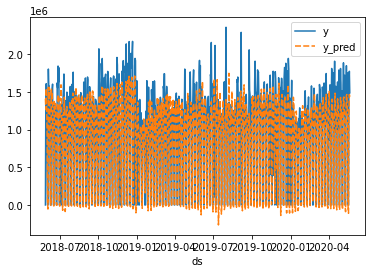

=== t+7 ===
R^2: 0.775
MAE: 200680.884



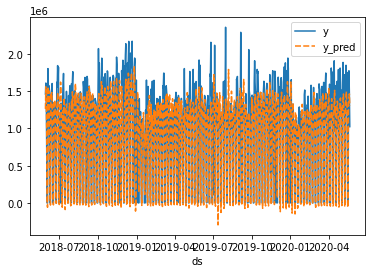

In [ ]:
models = [y_pred_cnn, y_pred_lstm]
weights = [1, 3]

y_pred_ensemble = np.average( np.array(models), axis=0, weights=weights)
evaluate(y_pred_ensemble)

### Statistical Models

#### Exponential Smoothing

In [ ]:
df_train.describe()

y      holiday
count  2.302000e+03  2302.000000
mean   7.613237e+05     0.026933
std    6.515448e+05     0.161923
min    0.000000e+00     0.000000
25%    0.000000e+00     0.000000
50%    1.007389e+06     0.000000
75%    1.312857e+06     0.000000
max    1.999348e+06     1.000000

In [ ]:
hist = df_train[target_col].copy() # Predict based on historical data. Start with the training data
hist.index.freq = pd.infer_freq(hist.index) # To avoid warnings, explicitly specify the dataframe frequency
n_pred = len(df_test) + 1 # Number of predictions: 1 on the training set; and then 1 for each additional 
y_pred_es = np.empty([n_pred,n_output_steps]) # Create an array to hold predictions, with a number of predictions equal to the test set size, each containing the # of time steps we are predicting forward.

for t in range(n_pred):
    mod = ExponentialSmoothing(hist, seasonal_periods=n_seasons, trend='add', seasonal='add', damped=True)
    res = mod.fit(use_boxcox=False)
    pred = res.forecast(n_output_steps)
    y_pred_es[t] = pred.values
    if t < n_pred - 1:
        hist.loc[df_test.iloc[t].name] = df_test[target_col][t] # Append the latest test data row to the history, for fitting the next model
        hist.index.freq = pd.infer_freq(hist.index)

=== t+(1-7) ===
R^2: 0.777
MAE: 194183.107

=== t+1 ===
R^2: 0.779
MAE: 192931.68



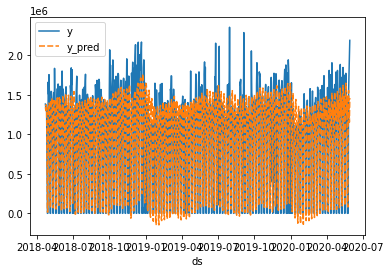

=== t+2 ===
R^2: 0.776
MAE: 194167.076



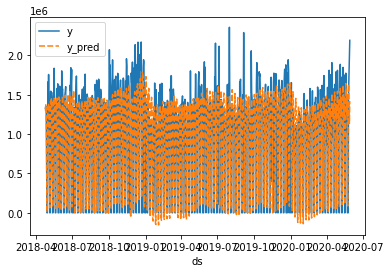

=== t+3 ===
R^2: 0.774
MAE: 194110.735



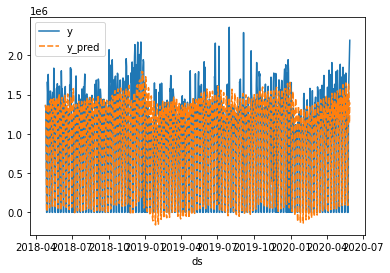

=== t+4 ===
R^2: 0.777
MAE: 193711.593



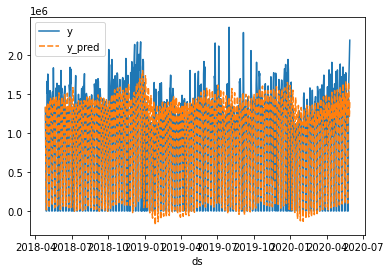

=== t+5 ===
R^2: 0.778
MAE: 193825.167



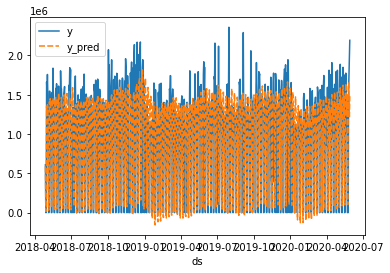

=== t+6 ===
R^2: 0.78
MAE: 193503.466



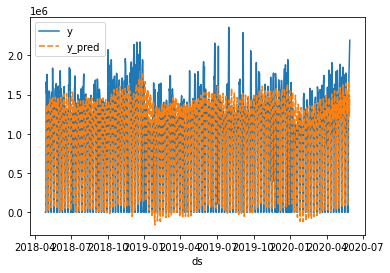

=== t+7 ===
R^2: 0.776
MAE: 197046.059



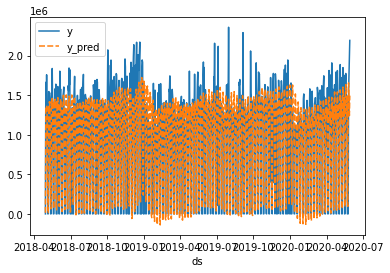

In [ ]:
evaluate(y_pred_es, 0)

#### Ensemble ML and Statistical Models

In [ ]:
def trunc(df, test_set=df_test, n_input_steps = n_input_steps, n_output_steps = n_output_steps):
  return df[n_input_steps: -n_output_steps]

y_pred_es_trunc = trunc(y_pred_es)
y_true_trunc = trunc(df_test)

=== t+(1-7) ===
R^2: 0.792
MAE: 184406.622

=== t+1 ===
R^2: 0.79
MAE: 188288.024



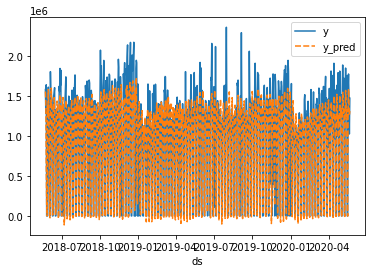

=== t+2 ===
R^2: 0.79
MAE: 186588.847



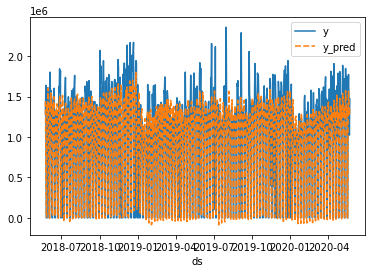

=== t+3 ===
R^2: 0.789
MAE: 184570.892



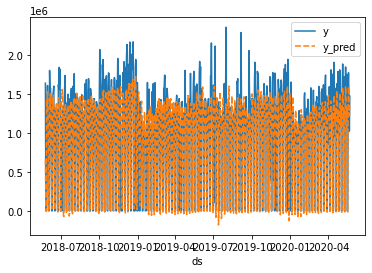

=== t+4 ===
R^2: 0.792
MAE: 185087.255



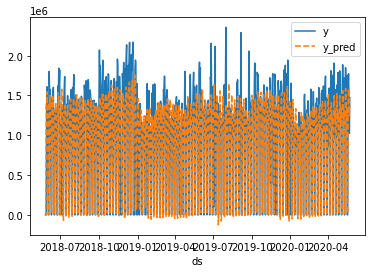

=== t+5 ===
R^2: 0.793
MAE: 183010.222



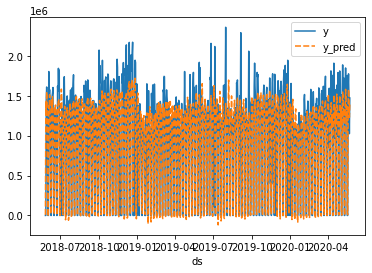

=== t+6 ===
R^2: 0.792
MAE: 182109.693



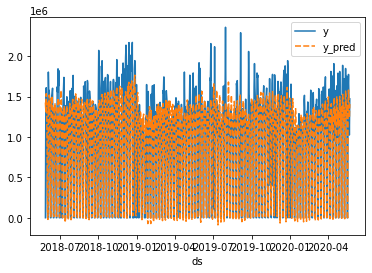

=== t+7 ===
R^2: 0.797
MAE: 181147.549



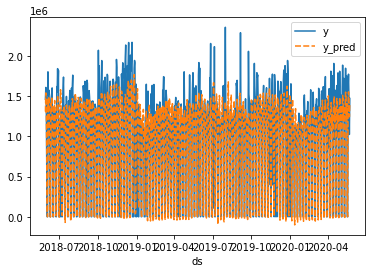

In [ ]:

models = [y_pred_cnn, y_pred_lstm, y_pred_es_trunc]
weights = [1, 1, 1]

y_pred_ensemble = np.average( np.array(models), axis=0, weights=weights)

evaluate(y_pred_ensemble, 0, y_true_trunc)